<font size=7> Latencies Analysis

In [11]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, plot_latency_dist_hist, plot_latency_angle_hist, \
                                 plot_cross_sttc_pairs, latencies
from human_hip.animate import animate_latencies
import human_hip.spike_data as spike_data

from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, cross_sttc, plot_pair_analysis, plot_cross_sttc_pairs
import pickle
import matplotlib.pyplot as plt
from ipywidgets import interact_manual
import numpy as np
import pickle
from ipywidgets import interact_manual, interact

In [4]:
sd = read_phy_files( "/workspaces/human_hippocampus/data/ephys/2022-11-02-e-Hc11.1-chip16753/derived/kilosort2/hc11.1_plated-11.1_chip-16753_rec_11.2.22AM-immediate_curated.zip" )


In [17]:
from ipywidgets import interact_manual, interact
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator

def plot_latency_angle_hist( sd, pairs, pair_latencies, by_firing_rate=True ):
    """
    Inputs:
        sd: SpikeData object
        pairs: np.array of neuron indices (as pairs) for which a connection exists, ex: [[0,1], [0,2], [2,3]]
        by_firing_rate: boolean, if True, the angle histogram will be weighted by the number of latencies for each pair
        late_cutoff_low: integer, the lower bound of the latency cutoff
        late_cutoff_high: integer, the upper bound of the latency cutoff
    Outputs:
        A plot depicting the histogram of the angles of the pairs
    """
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)
    
    # We assume pair point in same direction

    # Creat arrows show angle of information flow from a neuron
    starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ pairs[:,1] ]
    angle = np.arctan2(-(ends[:,1]-starts[:,1]), ends[:,0]-starts[:,0]) * -1

    if by_firing_rate:
        latency_counts= []
        for a_latency in pair_latencies:
            latency_counts.append( sum(a_latency>0) )
        latency_counts= np.array(latency_counts)
        angle = np.repeat( angle, latency_counts )

    #n_bins = 30  # You can adjust the number of bins here
    counts, bin_edges = np.histogram(angle,  density=True)  #bins=n_bins,
    bin_width = np.diff(bin_edges)
    cmap = cm.get_cmap('hsv')
    bin_angles= (bin_edges[:-1] - bin_edges.min()) / (bin_edges.max() - bin_edges.min())
    bin_angles = bin_angles[::-1] #+ .05
    bin_colors = cmap(bin_angles)

    ax = plt.subplot(111, polar=True)
    for idx, count in enumerate(counts):
        ax.bar(bin_edges[idx], count, width=bin_width[idx], color=bin_colors[idx], align='edge')
    #ax.set_yticks([0,.1,.2,.3,.4])
    ax.yaxis.set_major_locator(MaxNLocator(5))
    plt.title('Pair Angle Histogram')
    plt.show()

# Get Latencies

In [6]:
count = 0
for i in range(sd.N):
    for j in range(i+1,sd.N):
        count+=1
        if count % 1000 == 0:
            print(f"Count has reached {count}")

Count has reached 1000
Count has reached 2000
Count has reached 3000


In [9]:
pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
all_latencies = []
count = 0
for i in range(sd.N):
    for j in range(i+1,sd.N):
        count+=1
        if count % 1000 == 0:
            print(f"Count has reached {count}")
        pairs.append([i,j])
        all_latencies.append(  latencies( i, j, sd, ms_cutoff_high=150) )


Count has reached 1000
Count has reached 2000
Count has reached 3000


(array([2.139e+03, 5.960e+02, 3.240e+02, 1.590e+02, 1.360e+02, 7.800e+01,
        6.500e+01, 3.300e+01, 2.900e+01, 2.600e+01, 2.500e+01, 1.700e+01,
        1.200e+01, 1.200e+01, 9.000e+00, 1.000e+01, 4.000e+00, 1.200e+01,
        3.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 7.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

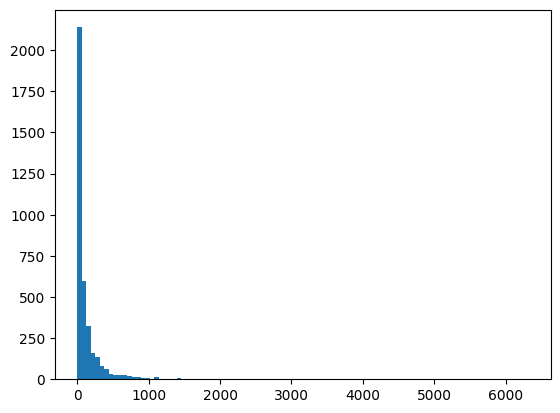

In [12]:
len_all_pair_latencies = []
for i in range(len(all_latencies)):
    len_all_pair_latencies.append(len(all_latencies[i]))
plt.hist(len_all_pair_latencies, bins=100)

In [13]:
curated_latencies = []
curated_pairs = []
for i in range(len(all_latencies)):
    pair_latencies = all_latencies[i]
    if abs(np.mean(pair_latencies))> 20 and len(pair_latencies)>150: #abs(np.median(pair_latencies))> 1.5 and 
        if np.mean(pair_latencies) < 0:
            curated_pairs.append( [ pairs[i][1], pairs[i][0] ] )   #lags_late.append( latency )
            curated_latencies.append( pair_latencies * -1 )
        else:
            curated_pairs.append( pairs[i] ) 
            curated_latencies.append( pair_latencies )
#curated_pairs.append( pairs[i] )
print(len(curated_latencies))
curated_pairs = np.array(curated_pairs)

3


/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Plot

In [ ]:
# dump all_latencies into a pickl file
# with open('chip21769_latencies.pkl', 'wb') as f:
#     pickle.dump({"latencies":curated_latencies,"pairs":curated_pairs}, f)
# Load latencies
# with open('chip21769_curated_latencies.pkl', 'rb') as f:
#     data = pickle.load(f)
#     curated_latencies = data["latencies"]
#     curated_pairs = data["pairs"]


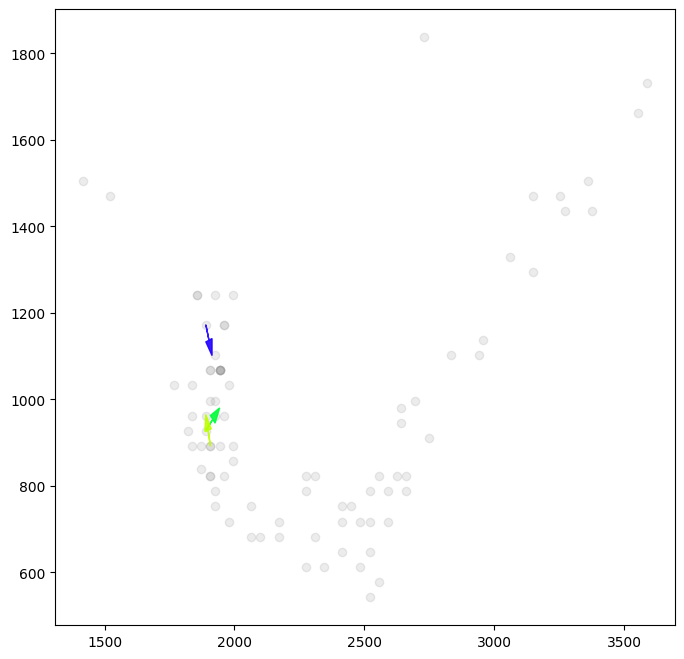

In [14]:
plot_vector_layout( sd, np.array(curated_pairs)  )

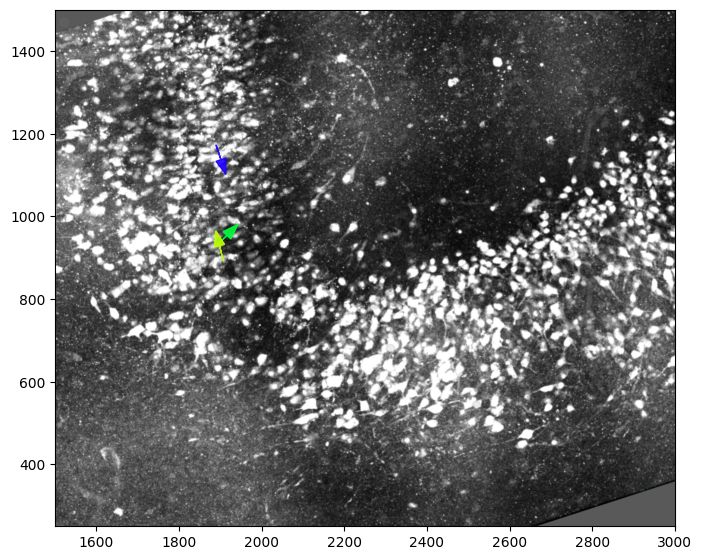

In [16]:
plot_vector_layout( sd,curated_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc111_bw.png", xlim=(1500,3000), ylim=(250,1500))

/tmp/ipykernel_56748/785088481.py:17: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_56748/785088481.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


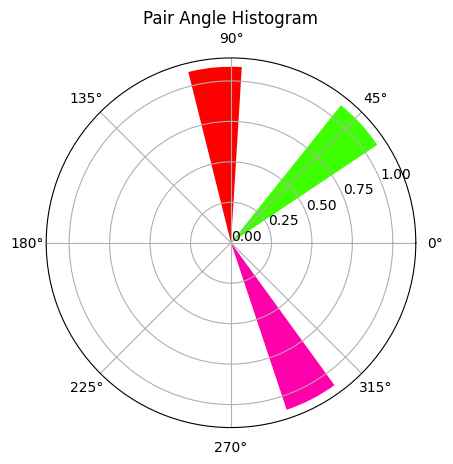

In [18]:
plot_latency_angle_hist( sd, curated_pairs, curated_latencies, by_firing_rate=False )